<a href="https://colab.research.google.com/github/jgbrenner/psychometrics/blob/main/Final_model_PsychC9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generating Psychometric Scale Items in Polish Measuring Perfectionism Using Generative AI and Conducting Exploratory Graph Analysis**



# Methodology

# Overview

In this notebook, I will utilize a large language model (LLM) to generate items for a psychometric scale measuring three dimensions of perfectionism: Self-Oriented Perfectionism, Other-Oriented Perfectionism, and Socially Conditioned Perfectionism. Following item generation, I will perform Exploratory Graph Analysis (EGA) to validate the structure and dimensionality of the generated items. The goal is to select the top six items for each type, generating a scale of 18 items.


# Steps Involved

Item Generation:
I prompted the LLM to generate six items for each construct. The output was formatted in JSON for easy processing.
The constructs targeted are:

- Self-Oriented Perfectionism

- Other-Oriented Perfectionism

- Socially Conditioned Perfectionism


# Data Preparation:

The generated items were compiled into a data frame, and constructs were extracted for further analysis.
An embeddings array was created to represent the items in a high-dimensional space suitable for EGA.

# Transfer to R:

The embeddings array and constructs list were transferred from Python to R using the rpy2 interface.

# Exploratory Graph Analysis (EGA):

In R, the embeddings array was converted into a matrix format, with appropriate row names assigned based on the constructs.
The EGAnet library was utilized to perform EGA on the embeddings matrix, allowing for an exploration of the underlying structure of the psychometric items.

Results were printed and visualized to assess the dimensionality of the constructs.

# Conclusion
This methodology enables a systematic approach to generating and validating psychometric scale items, ensuring that they are both relevant and statistically sound.

In [1]:
# Install necessary Python packages
!pip install openai groq # numpy and pandas come pre-installed in colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.3 MB/s eta 0:00:00


In [2]:
# Install rpy2 for R and Python integration
!pip install rpy2

# Load the R magic extension for rpy2
%load_ext rpy2.ipython

In [3]:
# Import necessary Python libraries
import os
import openai
import pandas as pd
import numpy as np
import json
import requests
import re
from google.colab import drive, userdata

In [4]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path where the R library will be saved in Google Drive
library_path = '/content/drive/MyDrive/R_libraries'

# Create the directory if it doesn't exist
if not os.path.exists(library_path):
    os.makedirs(library_path)

# Verify rpy2 version as this is known to cause errors (version 3.4.2 works fine)
import rpy2
print(f"rpy2 version: {rpy2.__version__}")

Mounted at /content/drive
rpy2 version: 3.4.2


In [5]:
# Fetching the OpenAI API key from Colab secrets
openai_api_key = userdata.get('OPENAI_API_KEY')
if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
else:
    raise ValueError("OPENAI_API_KEY is not set or invalid.")

# Fetching the Groq API key from Colab secrets
groq_api_key = userdata.get('GROQ_API_KEY')
if groq_api_key:
    os.environ["GROQ_API_KEY"] = groq_api_key
else:
    raise ValueError("GROQ_API_KEY is not set or invalid.")



# Initialize the Groq client (if needed)
#from groq import Groq
#client = Groq(api_key=groq_api_key)



# Import OpenAI Client
from openai import Client
client = Client()

# Prompting is everythig

Designing the prompt to get psychometric scale items measuiring three dimentions of perfectionism. Note that temperature above 1.5 creates lower quality results. Same with temperatures below 0.5. The model is capable of exporting the statements in JSON format.

In [12]:
# Prompting GPT-4o-mini to generate items
messages = [
    {
        "role": "system",
        "content": "Jesteś ekspertem w psychometrii, który tworzy pytania testowe."
    },
    {
        "role": "user",
        "content": (
            "Wygeneruj po 33 stwierdzenia dla każdego z następujących konstruktów: "
            "Perfekcjonizm skierowany na siebie: Tendencja do wymagania doskonałości od siebie samego, "
            "Perfekcjonizm skierowany na innych: Stawianie wysokich oczekiwań wobec innych i krytyczna ocena ich osiągnięć, "
            "Perfekcjonizm społecznie narzucony: Przekonanie, że inni oczekują od nas doskonałości. "
            "Niech stwierdzenia będą zwięzłe i jasne,  odpowiednie do oceny w skali Likerta. "
            "Provide the output ONLY in JSON format as a list of dictionaries, "
            "without any additional text or explanation. "
            "Each dictionary should have keys 'construct' and 'item'."
        )
    }
]



# Call the API to generate items
try:
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.7, # modify temperature for rigidity or creativity
        max_tokens=8048,
        top_p=1, # value of 1 top consider all tokens
        stream=False
    )
    response_content = completion.choices[0].message.content
    print("\nGenerated Items:\n", response_content)
except Exception as e:
    print(f"An error occurred: {e}")
    response_content = ""


Generated Items:
 ```json
[
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję, że muszę być doskonały w każdej dziedzinie."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Często jestem niezadowolony z własnych osiągnięć."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Nie potrafię zaakceptować swoich błędów."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję presję, aby zawsze osiągać najlepsze wyniki."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Stawiam sobie bardzo wysokie cele."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję się winny, gdy nie osiągam perfekcji."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Zdarza mi się porównywać się do innych, aby ocenić swoje sukcesy."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję, że moje osiągnięcia muszą być lepsze niż innych."},
    {"construct": "Perfekcjonizm 

In [15]:
# Print the raw response content for debugging
print("Raw Response Content:")
print(response_content)

# Attempt to parse the JSON response
try:
    generated_items = json.loads(response_content)
    items_df = pd.DataFrame(generated_items)
except json.JSONDecodeError as e:
    print(f"JSON parsing failed: {e}")
    # Attempt to extract valid JSON content from the response
    json_match = re.search(r'\[.*\]', response_content, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        print("Extracted JSON String:")
        print(json_str)  # Print the extracted JSON string for verification
        try:
            generated_items = json.loads(json_str)
            items_df = pd.DataFrame(generated_items)
        except json.JSONDecodeError as e2:
            print(f"Second JSON decoding attempt failed: {e2}")
            items_df = None
    else:
        print("No valid JSON found in the response.")
        items_df = None

# Print the DataFrame to verify its contents before saving
if items_df is not None and not items_df.empty:
    print("Final DataFrame:")
    print(items_df)  # Show the DataFrame contents
    items_df.to_csv("generated_items_pool.csv", index=False)
    print("Generated items saved to 'generated_items_pool.csv'.")
else:
    print("No items to save.")

Raw Response Content:
```json
[
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję, że muszę być doskonały w każdej dziedzinie."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Często jestem niezadowolony z własnych osiągnięć."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Nie potrafię zaakceptować swoich błędów."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję presję, aby zawsze osiągać najlepsze wyniki."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Stawiam sobie bardzo wysokie cele."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję się winny, gdy nie osiągam perfekcji."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Zdarza mi się porównywać się do innych, aby ocenić swoje sukcesy."},
    {"construct": "Perfekcjonizm skierowany na siebie", "item": "Czuję, że moje osiągnięcia muszą być lepsze niż innych."},
    {"construct": "Perfekcjoni

In [17]:
# Prepare the list of items
if items_df is not None:
    # Clean and validate item texts
    item_texts = items_df["item"].tolist()
    item_texts = [item for item in item_texts if item.strip()]  # Filter empty strings

    # Set up the API endpoint and headers for OpenAI embeddings
    embedding_endpoint = "https://api.openai.com/v1/embeddings"
    embedding_model = "text-embedding-3-small"  # Using the specified model

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }

    # Prepare the data payload
    data = {
        "model": embedding_model,
        "input": item_texts
    }

    # Make the API request to generate embeddings
    try:
        response = requests.post(embedding_endpoint, headers=headers, json=data)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}: {response.text}")
            embeddings_array = None
        else:
            response_data = response.json()
            # Extract embeddings
            embeddings = [item['embedding'] for item in response_data['data']]
            embeddings_array = np.array(embeddings)
            print(f"Embeddings generated successfully. Shape: {embeddings_array.shape}")
            # Save the embeddings
            np.save("embeddings.npy", embeddings_array)
            print("Embeddings saved as 'embeddings.npy'.")
    except Exception as e:
        print(f"An error occurred during embedding generation: {e}")
        embeddings_array = None
else:
    print("Error: items_df is not defined. Cannot proceed with embedding generation.")
    embeddings_array = None

Embeddings generated successfully. Shape: (76, 1536)
Embeddings saved as 'embeddings.npy'.


In [20]:
# Define custom abbreviations for constructs
construct_abbreviations = {
    "Perfekcjonizm skierowany na siebie": "PSS",
    "Perfekcjonizm społecznie narzucony": "PSP",
    "Perfekcjonizm skierowany na innych": "PSI"
}

# Apply custom labels with error handling for unexpected constructs
if items_df is not None:
    items_df['item_label'] = items_df.apply(
        lambda row: f"{construct_abbreviations.get(row['construct'], 'UNK')}{row.name+1}", axis=1
    )

    # Verify the generated labels
    items_constructs = items_df['item_label'].tolist()
    print("Generated Item Labels:", items_constructs)

    # Combine item labels with their respective text
    labeled_items = items_df.apply(
        lambda row: f"{row['item_label']}: {row['item']}", axis=1
    ).tolist()

    # Print the list of labeled items
    print("Labeled Items List:")
    for item in labeled_items:
        print(item)

    # Export labeled items for R
    items_df.to_csv("psychometric_items.csv", index=False)
    print("Items exported to 'psychometric_items.csv'.")
else:
    print("No items to label or export.")

Generated Item Labels: ['PSS1', 'PSS2', 'PSS3', 'PSS4', 'PSS5', 'PSS6', 'PSS7', 'PSS8', 'PSS9', 'PSS10', 'PSS11', 'PSS12', 'PSS13', 'PSS14', 'PSS15', 'PSS16', 'PSS17', 'PSS18', 'PSS19', 'PSS20', 'PSS21', 'PSS22', 'PSS23', 'PSS24', 'PSS25', 'PSS26', 'PSS27', 'PSS28', 'PSS29', 'PSS30', 'PSI31', 'PSI32', 'PSI33', 'PSI34', 'PSI35', 'PSI36', 'PSI37', 'PSI38', 'PSI39', 'PSI40', 'PSI41', 'PSI42', 'PSI43', 'PSI44', 'PSI45', 'PSI46', 'PSI47', 'PSI48', 'PSI49', 'PSI50', 'PSI51', 'PSP52', 'PSP53', 'PSP54', 'PSP55', 'PSP56', 'PSP57', 'PSP58', 'PSP59', 'PSP60', 'PSP61', 'PSP62', 'PSP63', 'PSP64', 'PSP65', 'PSP66', 'PSP67', 'PSP68', 'PSP69', 'PSP70', 'PSP71', 'PSP72', 'PSP73', 'PSP74', 'PSP75', 'PSP76']
Labeled Items List:
PSS1: Czuję, że muszę być doskonały w każdej dziedzinie.
PSS2: Często jestem niezadowolony z własnych osiągnięć.
PSS3: Nie potrafię zaakceptować swoich błędów.
PSS4: Czuję presję, aby zawsze osiągać najlepsze wyniki.
PSS5: Stawiam sobie bardzo wysokie cele.
PSS6: Czuję się winny, 

In [21]:
# Pass variables to R for further analysis
if embeddings_array is not None and items_df is not None:
    # Prepare data to pass to R
    item_labels = items_df['item_label'].tolist()
    constructs = items_df['construct'].tolist()
    # Pass variables from Python to R
    %R -i embeddings_array -i item_labels -i constructs -i library_path
else:
    print("Cannot proceed to R analysis due to missing data.")

In [37]:
%%R

# Set the custom library path
.libPaths(library_path)

# List of required packages
required_packages <- c("EGAnet", "aricode", "psych", "dplyr", "stringr", "readr", "qgraph")

# Install and load necessary R packages
for (pkg in required_packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg, lib = library_path, dependencies = TRUE)
    }
    library(pkg, character.only = TRUE)
}

In [23]:
%%R

# Load the embeddings and item information
embeddings_matrix <- as.matrix(embeddings_array)
rownames(embeddings_matrix) <- item_labels

# Compute the correlation matrix between items
cor_matrix <- cor(t(embeddings_matrix))

# Remove any potential NA values
cor_matrix[is.na(cor_matrix)] <- 0

In [24]:
%%R

# Apply Unique Variable Analysis (UVA) to identify redundant items
uva_result <- UVA(
    data = cor_matrix,
    n = nrow(cor_matrix),
    method = "wTO",
    threshold = 0.20  # Adjusted threshold as per AI-GENIE method
)

# Items to remove (redundant items)
redundant_items <- uva_result$redundant

# Print redundant items
print("Redundant Items:")
print(redundant_items)

[1] "Redundant Items:"
$PSP53
[1] "PSP57"

$PSI31
[1] "PSI38"

$PSS1
[1] "PSS28"

$PSS26
[1] "PSP68"

$PSP60
[1] "PSP74"

$PSS24
[1] "PSP62"

$PSP52
[1] "PSP63"

$PSI32
[1] "PSI46"

$PSS20
[1] "PSP69"



In [25]:
%%R

# Remove redundant items from embeddings and correlation matrix
embeddings_matrix_reduced <- embeddings_matrix[!rownames(embeddings_matrix) %in% redundant_items, ]
cor_matrix_reduced <- cor_matrix[!rownames(cor_matrix) %in% redundant_items, !colnames(cor_matrix) %in% redundant_items]

# Update item_labels and constructs
item_labels_reduced <- item_labels[!item_labels %in% redundant_items]
constructs_reduced <- constructs[!item_labels %in% redundant_items]

# Ensure constructs_reduced and item_labels_reduced are vectors
constructs_reduced <- as.vector(constructs_reduced)
item_labels_reduced <- as.vector(item_labels_reduced)

# Ensure alignment between constructs_reduced and item_labels_reduced
names(constructs_reduced) <- item_labels_reduced

In [28]:
%%R

print("Known Communities Structure:")
print(str(known_communities))

print("Detected Communities Structure:")
print(str(detected_communities))

[1] "Known Communities Structure:"
List of 67
 $ PSS1 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS2 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS3 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS4 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS5 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS6 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS7 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS8 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS9 : chr "Perfekcjonizm skierowany na siebie"
 $ PSS10: chr "Perfekcjonizm skierowany na siebie"
 $ PSS11: chr "Perfekcjonizm skierowany na siebie"
 $ PSS12: chr "Perfekcjonizm skierowany na siebie"
 $ PSS13: chr "Perfekcjonizm skierowany na siebie"
 $ PSS14: chr "Perfekcjonizm skierowany na siebie"
 $ PSS15: chr "Perfekcjonizm skierowany na siebie"
 $ PSS16: chr "Perfekcjonizm skierowany na siebie"
 $ PSS17: chr "Perfekcjonizm skierowany na siebie"
 $ PSS18: chr "Perfekcjonizm skierowany na siebie"
 $ PSS19: chr "Perfekcjonizm skierow

EGA algo from perplexity: previous code in cell:
%%R

# Determine optimal step size for Walktrap algorithm using NMI
library(aricode)

# Known communities (constructs)
known_communities <- constructs_reduced
names(known_communities) <- item_labels_reduced

# Initialize NMI values
nmi_values <- numeric(10)

for (step_size in 1:10) {
    ega_result <- EGA(
        data = cor_matrix_reduced,
        corr = "auto",
        n = nrow(cor_matrix_reduced),
        model = "glasso",
        algorithm = "walktrap",
        steps = step_size,
        plot.EGA = FALSE
    )
    # Detected communities
    detected_communities <- ega_result$wc
    # Ensure detected_communities is a vector
    detected_communities <- as.vector(detected_communities)
    # Compute NMI
    nmi <- NMI(known_communities, detected_communities)
    nmi_values[step_size] <- nmi
}

# Find the step size with the highest NMI
optimal_step <- which.max(nmi_values)
cat("Optimal step size is:", optimal_step, "with NMI:", nmi_values[optimal_step], "\n")

In [30]:
%%R

# Determine optimal step size for Walktrap algorithm using NMI
library(aricode)

# Known communities (constructs)
known_communities <- constructs_reduced
names(known_communities) <- item_labels_reduced

# Convert known communities to a character vector
known_communities_vector <- as.vector(unlist(known_communities))  # Ensure it's a vector

# Initialize NMI values
nmi_values <- numeric(10)

for (step_size in 1:10) {
    ega_result <- EGA(
        data = cor_matrix_reduced,
        corr = "auto",
        n = nrow(cor_matrix_reduced),
        model = "glasso",
        algorithm = "walktrap",
        steps = step_size,
        plot.EGA = FALSE
    )

    # Detected communities
    detected_communities <- ega_result$wc

    # Ensure detected communities are treated as factors
    detected_communities <- as.factor(as.vector(unlist(detected_communities)))  # Flatten if necessary

    # Check if known communities are in the correct format
    known_communities_vector <- as.factor(known_communities_vector)

    # Compute NMI
    nmi <- NMI(known_communities_vector, detected_communities)
    nmi_values[step_size] <- nmi
}

# Find the step size with the highest NMI
optimal_step <- which.max(nmi_values)
cat("Optimal step size is:", optimal_step, "with NMI:", nmi_values[optimal_step], "\n")

Optimal step size is: 4 with NMI: 0.1735343 


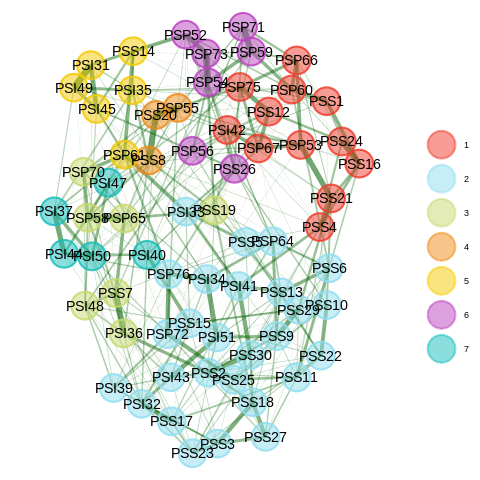

In [31]:
%%R

# Perform final EGA with optimal step size
final_ega <- EGA(
    data = cor_matrix_reduced,
    corr = "auto",
    n = nrow(cor_matrix_reduced),
    model = "glasso",
    algorithm = "walktrap",
    steps = optimal_step,
    plot.EGA = TRUE
)

# Extract community assignments
community_assignments <- final_ega$wc

In [38]:
%%R

# Compute centrality measures
centrality_results <- centrality(final_ega)

# Extract strength centrality
strength_centrality <- centrality_results$Strength

# Create a data frame with item labels, constructs, and centrality
items_final <- data.frame(
    item_label = rownames(cor_matrix_reduced),
    construct = constructs_reduced,
    strength = strength_centrality,
    community = community_assignments
)

  no applicable method for 'getWmat' applied to an object of class "EGA"




Error in UseMethod("getWmat") : 
  no applicable method for 'getWmat' applied to an object of class "EGA"


In [41]:
%%R

str(final_ega)
summary(final_ega)


List of 8
 $ network      : num [1:67, 1:67] 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:67] "PSS1" "PSS2" "PSS3" "PSS4" ...
  .. ..$ : chr [1:67] "PSS1" "PSS2" "PSS3" "PSS4" ...
  ..- attr(*, "methods")=List of 9
  .. ..$ corr            : chr "auto"
  .. ..$ model.selection : chr "ebic"
  .. ..$ lambda          : num 0.0912
  .. ..$ gamma           : num 0.25
  .. ..$ lambda.min.ratio: num 0.1
  .. ..$ nlambda         : num 100
  .. ..$ criterion       : num 3840
  .. ..$ model           : chr "glasso"
  .. ..$ na.data         : chr "pairwise"
 $ wc           : 'EGA.community' Named num [1:67] 1 2 2 1 2 2 3 4 2 2 ...
  ..- attr(*, "names")= chr [1:67] "PSS1" "PSS2" "PSS3" "PSS4" ...
  ..- attr(*, "methods")=List of 2
  .. ..$ algorithm         : chr "Walktrap"
  .. ..$ objective_function: NULL
 $ n.dim        : int 7
 $ correlation  : num [1:67, 1:67] 1 0.472 0.436 0.633 0.398 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:67] "PSS1" "PSS2" "PSS3" "

In [19]:
# Prepare the list of items
if items_df is not None:
    # Clean and validate item texts
    item_texts = items_df["item"].tolist()
    item_texts = [item for item in item_texts if item.strip()]  # Filter empty strings

    # Set up the API endpoint and headers for OpenAI embeddings
    embedding_endpoint = "https://api.openai.com/v1/embeddings"
    embedding_model = "text-embedding-3-small"  # Using the specified model

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }

    # Prepare the data payload
    data = {
        "model": embedding_model,
        "input": item_texts
    }

    # Make the API request to generate embeddings
    try:
        response = requests.post(embedding_endpoint, headers=headers, json=data)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}: {response.text}")
            embeddings_array = None
        else:
            response_data = response.json()
            # Extract embeddings
            embeddings = [item['embedding'] for item in response_data['data']]
            embeddings_array = np.array(embeddings)
            print(f"Embeddings generated successfully. Shape: {embeddings_array.shape}")
            # Save the embeddings
            np.save("embeddings.npy", embeddings_array)
            print("Embeddings saved as 'embeddings.npy'.")
    except Exception as e:
        print(f"An error occurred during embedding generation: {e}")
        embeddings_array = None
else:
    print("Error: items_df is not defined. Cannot proceed with embedding generation.")
    embeddings_array = None

Embeddings generated successfully. Shape: (76, 1536)
Embeddings saved as 'embeddings.npy'.


Print correlation matrix heatmap

# Podsumowanie analizy czynnikowej
Przeprowadzona analiza czynnikowa (EFA) potwierdziła istnienie trzech czynników, które odpowiadają teoretycznym konstruktom:

- Perfekcjonizm skierowany na siebie (PSS) – Tendencja do stawiania wysokich wymagań wobec siebie.

- Perfekcjonizm skierowany na innych (PSI) – Stawianie wysokich oczekiwań wobec innych osób i krytyczna ocena ich osiągnięć.

- Perfekcjonizm społecznie narzucony (PSP) – Przekonanie, że inni oczekują od nas doskonałości.

# Główne wyniki:
Trzy czynniki wyjaśniają 63% całkowitej wariancji danych, co świadczy o dobrej strukturze czynnikowej.
- Pierwszy czynnik (ML3) wyjaśnia 25% wariancji, drugi (ML1) – 22%, a trzeci (ML2) – 17%.

- RMSR (Root Mean Square Residuals) wynosi 0.04, co wskazuje na dobrą jakość dopasowania modelu do danych.

# Obserwacje dotyczące pozycji testowych:
Większość pozycji testowych dobrze ładuje się na przypisane czynniki:
- PSS4 (ładowanie: 0.73 na ML3) i PSP14 (ładowanie: 0.61 na ML1) są silnie powiązane z odpowiednimi konstrukcjami.

- Niektóre pozycje wykazują wysoką złożoność (cross-loading):
PSI9 ładuje się na wszystkie trzy czynniki, co może sugerować pewną niejednoznaczność w jej treści.

- PSS6 wykazuje niską wartość wspólnoty (h2 = 0.28), co może świadczyć o słabej reprezentatywności dla danego konstruktu.

Występuje umiarkowane nakładanie się konstrukcji, szczególnie między Perfekcjonizmem skierowanym na siebie (PSS) a Perfekcjonizmem społecznie narzuconym (PSP), co jest zgodne z ich teoretyczną bliskością.
# Wnioski:
- Struktura czynnikowa danych jest zgodna z założeniami teoretycznymi, co potwierdza trafność narzędzia.

- Pomimo pewnych obserwacji dotyczących pozycji (np. PSI9, PSS6), zdecydowano o zachowaniu wszystkich pozycji testowych w obecnej formie.
